# COMP90049 Introduction to Machine Learning, 2020 Semester 2

## The University of Melbourne, School of Computing and Information Systems
-----
## Project 2: Music Genre Prediction from Audio, Metadata and Text Features!
-----
###### Student Name(s): Xulin Yang
###### Python version: 3.6.5
###### Submission deadline: 5 PM 16 October

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from pprint import pprint
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import string
import re
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


In [2]:
RANDOM_STATE = 90049

In [3]:
def select_df1_columns_based_on_df2(df1: pd.DataFrame, df2: pd.DataFrame):
    return df1[list(df2.columns)]

# load dataset

In [4]:
def read_csv(file_path: str):
    return pd.read_csv(file_path)

In [5]:
test_features = read_csv('dataset/test_features.csv')
train_features = read_csv('dataset/train_features.csv')
train_labels = read_csv('dataset/train_labels.csv')
valid_features = read_csv('dataset/valid_features.csv')
valid_labels = read_csv('dataset/valid_labels.csv')

In [6]:
test_features = test_features.set_index('trackID')
train_features = train_features.set_index('trackID')
train_labels = train_labels.set_index('trackID')
valid_features = valid_features.set_index('trackID')
valid_labels = valid_labels.set_index('trackID')

# train test evaluate functions

## train

In [7]:
# this function train for input models given train X and train Y
def train(models: list, X: pd.DataFrame, Y: pd.DataFrame):
    trained = []
    for m in models:
        m.fit(X, Y.values.ravel())
        trained.append(m)
    return trained

## predict

In [8]:
# this function predict for input models given test X
def predict(models: list, X: pd.DataFrame):
    y_preds = []
    for m in models:
        preds = m.predict(X)
        y_preds.append(pd.DataFrame(preds, columns=["genre"], index=X.index))
    return y_preds

## evaluate

In [9]:
# This function should evaluate a set of predictions in terms of metrics
def evaluate(pred, true, average='macro'):
    CM = metrics.confusion_matrix(true, pred) # Confusion Matrix
    Acc = metrics.accuracy_score(true, pred) # Accuracy
#     'micro':
#         Calculate metrics globally by counting the total true positives, false 
#         negatives and false positives.

#     'macro':
#         Calculate metrics for each label, and find their unweighted mean. This 
#         does not take label imbalance into account.

#     'weighted':
#         Calculate metrics for each label, and find their average weighted by 
#         support (the number of true instances for each label). This alters 
#         ‘macro’ to account for label imbalance; it can result in an F-score that 
#         is not between precision and recall.
#   
#   As we have imbalanced class distribution, we use macro
    precf1 = metrics.precision_recall_fscore_support(true, pred, average=average) # Precision, Recall and F1-score
    return CM, Acc, precf1

## helper function

In [10]:
def select_audio_features(data: pd.DataFrame):
    tmp = pd.DataFrame()
    for i in range(1, 148+1):
        tmp["vect_" + str(i)] = data["vect_" + str(i)]
    return tmp

In [11]:
def select_meta_data_features(data: pd.DataFrame):
    tmp = data.copy()
    if "key" in data.columns:
        tmp = tmp[["loudness", "tempo", "time_signature", "key", "mode", "duration"]]
    else:
        tmp = tmp[["loudness", "tempo", "time_signature", 
                   "key_0", 
                   "key_1", 
                   "key_2", 
                   "key_3", 
                   "key_4", 
                   "key_5", 
                   "key_6", 
                   "key_7", 
                   "key_8", 
                   "key_9", 
                   "key_10", 
                   "key_11", 
                   "mode", "duration"]]
    return tmp

In [12]:
def one_hot_encoding(data: pd.DataFrame, column_name):
    new_df = data.copy()
    new_df = pd.get_dummies(new_df, prefix=column_name, columns=[column_name])
    
    return new_df

In [13]:
def draw_k_line_chart(x, y, ylabel, title, xlabel="k"):
#     plt.figure(figsize=(10, 3))
    plt.plot(x, y, 'b-')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

# Exploratory data analysis & feature engineering

## label distribution

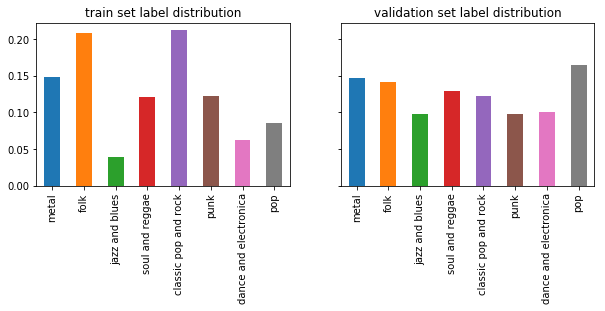

In [14]:
def draw_train_valid_label_distribution(train_labels: pd.DataFrame, valid_labels: pd.DataFrame, 
                                        title1='train set label distribution',
                                        title2='validation set label distribution'):
    xs = train_labels["genre"].unique()

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,3))
    ax1.set_title(title1)
    (train_labels["genre"].value_counts() / sum(train_labels["genre"].value_counts().sort_index()))[xs].plot(ax=ax1, kind='bar')

    ax2.set_title(title2)
    (valid_labels["genre"].value_counts() / sum(valid_labels["genre"].value_counts().sort_index()))[xs].plot(ax=ax2, kind='bar')
    plt.show()

draw_train_valid_label_distribution(train_labels, valid_labels)

## textual feature

### helper function

In [15]:
# modify from:
# https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X4gxmpMzafU

def clear_punctuations(text):
    for p in string.punctuation:
        text = text.replace(p, '')
    return text

def preprocess_tag(all_tags):
    result = []
    for tag in all_tags:
        tag = clear_punctuations(tag)
        result.append(tag)
    return result

def preprocess_title(all_titles):
    result = []
    for title in all_titles:
        trantab = str.maketrans({key: None for key in string.punctuation})
        title = title.translate(trantab)
        title = re.sub('\d+','',title)
        result.append(title)
    return np.array(result) 

def turn_TFIDF(train_corpus,corpus,note):
    if(note == 'tag'):
        corpus = preprocess_tag(corpus)
        train_corpus = preprocess_tag(train_corpus)
    if(note == 'title'):
        corpus = preprocess_title(corpus)
        train_corpus = preprocess_title(train_corpus)
    vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
    tfidf = vectorizer.fit(train_corpus)
    vectors = tfidf.transform(corpus)
    return pd.DataFrame(vectors.todense().tolist(), columns = vectorizer.get_feature_names())

### compute

In [16]:
tag_for_train = (train_features.iloc[:,1]).values
tag_for_valid = (valid_features.iloc[:,1]).values
tag_for_test = (test_features.iloc[:,1]).values

title_for_train = (train_features.iloc[:,0]).values
title_for_valid = (valid_features.iloc[:,0]).values
title_for_test = (test_features.iloc[:,0]).values

train_title = turn_TFIDF(title_for_train,title_for_train,'title').set_index(train_features.index)
valid_title = turn_TFIDF(title_for_train,title_for_valid,'title').set_index(valid_features.index)
test_title = turn_TFIDF(title_for_train,title_for_test,'title').set_index(test_features.index)

train_tag = turn_TFIDF(tag_for_train,tag_for_train,'tag').set_index(train_features.index)
valid_tag = turn_TFIDF(tag_for_train,tag_for_valid,'tag').set_index(valid_features.index)
test_tag = turn_TFIDF(tag_for_train,tag_for_test,'tag').set_index(test_features.index)

# train_tag

In [17]:
train_features_all = pd.concat([train_tag, 
                                select_meta_data_features(train_features), 
                                select_audio_features(train_features)], axis=1)
valid_features_all = pd.concat([valid_tag,
                                select_meta_data_features(valid_features), 
                                select_audio_features(valid_features)], axis=1)
test_features_all = pd.concat([test_tag, 
                               select_meta_data_features(test_features), 
                               select_audio_features(test_features)], axis=1)

# report

## tag, meta, audio or combination, which is good?

In [18]:
train_tag = train_tag.rename(columns={"tempo": "tempo_tag"})
valid_tag = valid_tag.rename(columns={"tempo": "tempo_tag"})
test_tag = test_tag.rename(columns={"tempo": "tempo_tag"})

In [19]:
all_features = pd.concat([train_features, valid_features, test_features], axis=0)
all_features_one_hot = one_hot_encoding(all_features, "key")
all_features_one_hot = all_features_one_hot.drop(columns=['title', 'tags'], axis=1)

# train_tag
train_meta = select_meta_data_features(all_features_one_hot).iloc[train_features.index, :]
train_audio = select_audio_features(all_features_one_hot).iloc[train_features.index, :]

train_all_features = train_tag.join(all_features_one_hot)
valid_all_features = valid_tag.join(all_features_one_hot)
test_all_features = test_tag.join(all_features_one_hot)

In [20]:
clf = GaussianNB()

names = ["tags", "meta", "audio", "tags+meta", "tags+audio", "meta+audio", "tags+meta+audio"]
trains = [train_tag, 
          train_meta,
          train_audio,
          select_df1_columns_based_on_df2(train_all_features, train_tag.join(train_meta)),
          select_df1_columns_based_on_df2(train_all_features, train_tag.join(train_audio)),
          select_df1_columns_based_on_df2(train_all_features, train_meta.join(train_audio)),
          train_all_features
         ]

f1s = []
for t in trains:
    clf.fit(t, train_labels.values.ravel())
    pred = clf.predict(select_df1_columns_based_on_df2(valid_all_features, t))
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    f1s.append(pref[2])

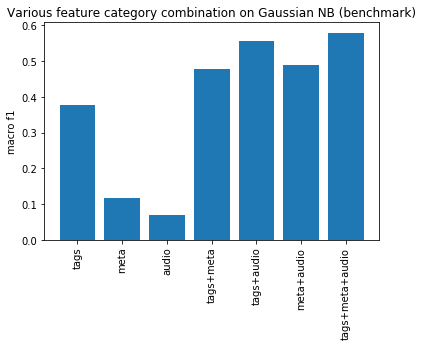

In [21]:
# plt.figure(figsize=[1, 6])
plt.bar(x= names, height=f1s)
plt.xticks(rotation=90)
plt.ylabel("macro f1")
plt.title("Various feature category combination on Gaussian NB (benchmark)")
plt.show()

## hyper-parameter tuning

### knn

In [420]:
scaler = StandardScaler()
scaler.fit(train_all_features)
train_all_features_standard = scaler.transform(train_all_features)
valid_all_features_standard = scaler.transform(valid_all_features)
test_all_features_standard = scaler.transform(test_all_features)

In [428]:
ks = []
f1s = [[], []]

k_max=200

metrics= ['euclidean', 'manhattan']

for k in range(1, k_max):
    models = [KNeighborsClassifier(n_neighbors=k, weights="distance", metric='euclidean'),
              KNeighborsClassifier(n_neighbors=k, weights="distance", metric='manhattan')]
    
    for i, m in enumerate(models):
        scores = cross_val_score(estimator=m, 
                        X=train_all_features_standard, 
                        y=train_labels.values.ravel(), 
                        cv=5,
                        scoring='f1_macro')
        f1s[i].append(np.mean(scores))
        print(k, metrics[i], k_max, np.mean(scores))
    ks.append(k)

# knn_clf = m

# knn_clf.fit(train_all_features, train_labels.values.ravel())

1 euclidean 200 0.2354660438242103
1 manhattan 200 0.22380132378915638
2 euclidean 200 0.2354660438242103
2 manhattan 200 0.22380132378915638
3 euclidean 200 0.23799492843051037
3 manhattan 200 0.19316053244629877
4 euclidean 200 0.23656192136836127
4 manhattan 200 0.2000676359152304
5 euclidean 200 0.23968699800584234
5 manhattan 200 0.18887054617194127
6 euclidean 200 0.24003692444554794
6 manhattan 200 0.18802687000912466
7 euclidean 200 0.23322500577237334
7 manhattan 200 0.17771993434950417
8 euclidean 200 0.22576012235390408
8 manhattan 200 0.17151626887403565
9 euclidean 200 0.2203108442963826
9 manhattan 200 0.16739571613171528
10 euclidean 200 0.21596221268591748
10 manhattan 200 0.16220204703025234
11 euclidean 200 0.2099604940189264
11 manhattan 200 0.16330910667505366
12 euclidean 200 0.20190210188455437
12 manhattan 200 0.1541479681629392
13 euclidean 200 0.19649447234365955
13 manhattan 200 0.15148447532093828
14 euclidean 200 0.1965270368491457
14 manhattan 200 0.1480328

KeyboardInterrupt: 

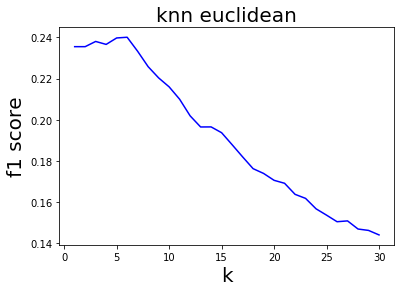

k maximize f1-score : 6 with 0.24003692444554794


In [729]:
draw_k_line_chart(ks[:30], f1s[0][:30], "f1 score", "knn euclidean")
knn_euclidean_k = ks[np.argmax(f1s[0])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[0][np.argmax(f1s[0])])

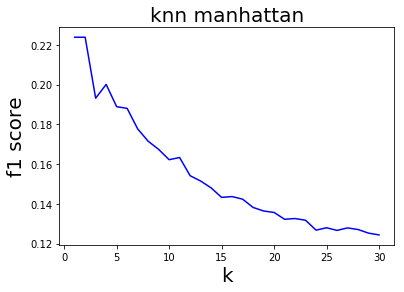

k maximize f1-score : 1 with 0.22380132378915638


In [736]:
draw_k_line_chart(ks[:30], f1s[1][:30], "f1 score", "knn manhattan")
knn_euclidean_k = ks[np.argmax(f1s[1])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[1][np.argmax(f1s[1])])

### dt

In [427]:
dt = DecisionTreeClassifier(criterion="entropy",
                            random_state=RANDOM_STATE)

dt_f1s = []
ds = [i for i in range(1, 36)] #len(train_dt.columns))]
for d in ds:
    dt.set_params(max_depth=d)

    scores = cross_val_score(estimator=dt, 
                        X=train_all_features, 
                        y=train_labels.values.ravel(), 
                        cv=5,
                        scoring='f1_macro')
    dt_f1s.append(np.mean(scores))
    
    print(d, np.mean(scores))

1 0.1269870507149139
2 0.2229490179566262
3 0.3280593258149846
4 0.3590542157636648
5 0.3810138740096459
6 0.41637049678555094
7 0.4267722975536536
8 0.43794641976077886
9 0.44689071072966496
10 0.4410342181234845
11 0.435978466142749
12 0.43382174624985315
13 0.4330280577491223
14 0.43441565318286424
15 0.4305731359445873
16 0.4266265562259254
17 0.4282033925957279
18 0.4224738098974131
19 0.4240862809134839
20 0.42522123095633557
21 0.4241165113840538
22 0.42607496947592727
23 0.42657997433145756
24 0.4243978924676341
25 0.4243978924676341
26 0.4243978924676341
27 0.4243978924676341
28 0.4243978924676341
29 0.4243978924676341
30 0.4243978924676341
31 0.4243978924676341
32 0.4243978924676341
33 0.4243978924676341
34 0.4243978924676341
35 0.4243978924676341


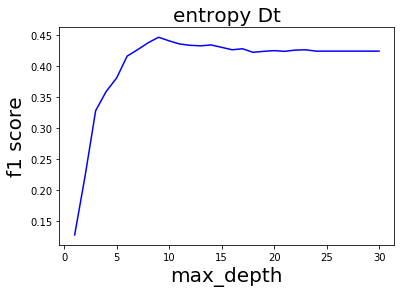

max_depth maximize f1-score : 9 with 0.44689071072966496


In [730]:
draw_k_line_chart(ds[:30], dt_f1s[:30], "f1 score", "entropy Dt", xlabel="max_depth")
best_md = ds[np.argmax(dt_f1s)]
print("max_depth maximize f1-score :", best_md, "with", dt_f1s[np.argmax(dt_f1s)])

### rf

In [ ]:
rf = RandomForestClassifier(n_estimators = 2000, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         max_depth=9)
rf_ns = [10, 100, 300, 500, 700, 1000, 1500]
rf_f1s = []

In [441]:
for ns in rf_ns:
    rf.set_params(n_estimators = ns)
    
    scores = cross_val_score(estimator=rf, 
                        X=train_all_features, 
                        y=train_labels.values.ravel(), 
                        cv=5,
                        scoring='f1_macro')
    rf_f1s.append(np.mean(scores))
    
    print(ns, np.mean(scores))

10 0.4336184980646694
100 0.4707763296717129
300 0.47797978092820725
500 0.4763764517524186
700 0.47728313435327285
1000 0.4779121358327143
1500 0.4767749808194763


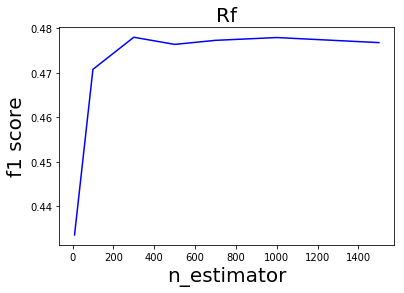

n_estimator maximize f1-score : 300 with 0.47797978092820725


In [731]:
draw_k_line_chart(rf_ns, rf_f1s, "f1 score", "Rf", xlabel="n_estimator")
best_rf_ns = rf_ns[np.argmax(rf_f1s)]
print("n_estimator maximize f1-score :", best_rf_ns, "with", rf_f1s[np.argmax(rf_f1s)])

### mlp

In [733]:
mlp = MLPClassifier(random_state=RANDOM_STATE, 
                                  max_iter=300,
                                  hidden_layer_sizes=100,
                                  activation='relu',
                                  solver='adam'
                                 )

hl_sizes = [(100), (100,100), (100,100,100), (100,100,100,100)]
xs = [i for i in range(1, len(hl_sizes)+1)]

mlp_f1s = []

In [734]:
for hl in hl_sizes:
    mlp.set_params(hidden_layer_sizes = hl)
    
    scores = cross_val_score(estimator=mlp, 
                        X=train_all_features_standard, 
                        y=train_labels.values.ravel(), 
                        cv=5,
                        scoring='f1_macro')
    mlp_f1s.append(np.mean(scores))
    
    print(hl, np.mean(scores))

100 0.5429877857042245
(100, 100) 0.5296416110685624
(100, 100, 100) 0.5366939574889715
(100, 100, 100, 100) 0.5378410781524601


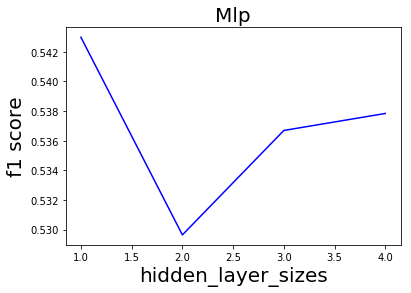

hidden_layer_size maximize f1-score : 100 with 0.5429877857042245


In [735]:
draw_k_line_chart(xs, mlp_f1s, "f1 score", "Mlp", xlabel="hidden_layer_sizes")
best_hl_ns = xs[np.argmax(mlp_f1s)] - 1
print("hidden_layer_size maximize f1-score :", str(hl_sizes[best_hl_ns]), "with", mlp_f1s[np.argmax(mlp_f1s)])

## model comparision

### compare

#### continous

In [699]:
models = [
    DummyClassifier(strategy="most_frequent"),
    GaussianNB(),
    make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=6, weights="distance", metric='euclidean')),
    DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
    RandomForestClassifier(n_estimators = 300, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         max_depth=9),
    make_pipeline(StandardScaler(), 
                 MLPClassifier(random_state=RANDOM_STATE, 
                                  max_iter=300,
                                  hidden_layer_sizes=100,
                                  activation='relu',
                                  solver='adam'
                                 )
                )
]

In [700]:
model_names = [
    "Zero-R",
    "Gaussian NB",
    "Knn",
    "Decision tree",
    "Random forest",
    "Multi-layer perceptron",
]

In [701]:
models = train(models, train_all_features, train_labels)

In [702]:
preds = predict(models, valid_all_features)

In [703]:
m_f1s = []
m_acc = []

for p in preds:
    _, acc, pref = evaluate(p, valid_labels.values.ravel())
    m_acc.append(acc)
    m_f1s.append(pref[2])
    

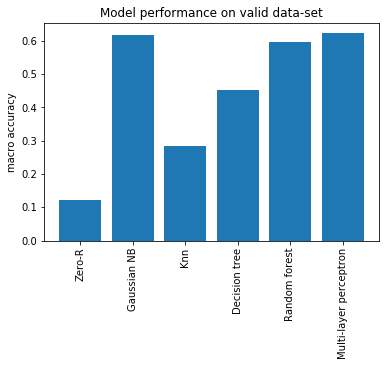

[('Zero-R', 0.12222222222222222),
 ('Gaussian NB', 0.6177777777777778),
 ('Knn', 0.28444444444444444),
 ('Decision tree', 0.4533333333333333),
 ('Random forest', 0.5977777777777777),
 ('Multi-layer perceptron', 0.6222222222222222)]


In [704]:
plt.bar(x=model_names, height=m_acc)
plt.ylabel("macro accuracy")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(model_names, m_acc)))

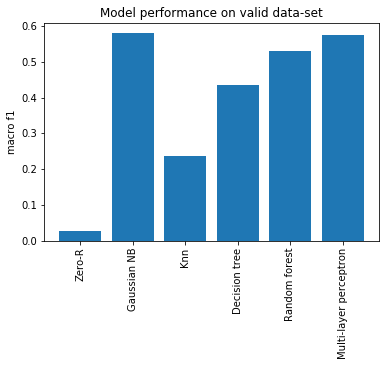

[('Zero-R', 0.027227722772277228),
 ('Gaussian NB', 0.5791759087379859),
 ('Knn', 0.23582657635076987),
 ('Decision tree', 0.4351733143531153),
 ('Random forest', 0.5295263553144117),
 ('Multi-layer perceptron', 0.5754623232960369)]


In [705]:
plt.bar(x=model_names, height=m_f1s)
plt.ylabel("macro f1")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(model_names, m_f1s)))

#### discrete

In [637]:
models = [
    DummyClassifier(strategy="most_frequent"),
    make_pipeline(KBinsDiscretizer(n_bins=10,
                                   encode='ordinal',
                                   strategy='quantile'
                                  ), 
                  MultinomialNB(alpha=1.0)),
    make_pipeline(KBinsDiscretizer(n_bins=10,
                                   encode='ordinal',
                                   strategy='quantile'
                                  ), 
                  CategoricalNB(alpha=1.0))
]

In [638]:
model_names = [
    "Zero-R",
    "Multinominal NB",
    "Categorical NB",
]

In [639]:
models = train(models, train_all_features, train_labels)

In [640]:
preds = predict(models, valid_all_features)

In [641]:
m_f1s = []
m_acc = []

for p in preds:
    _, acc, pref = evaluate(p, valid_labels.values.ravel())
    m_acc.append(acc)
    m_f1s.append(pref[2])

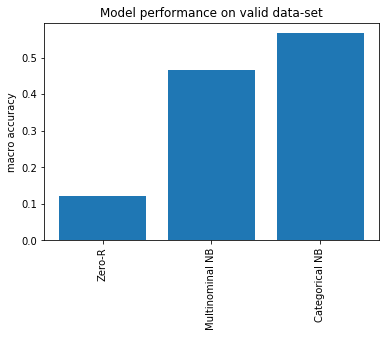

[('Zero-R', 0.12222222222222222),
 ('Multinominal NB', 0.4666666666666667),
 ('Categorical NB', 0.5666666666666667)]


In [642]:
plt.bar(x=model_names, height=m_acc)
plt.ylabel("macro accuracy")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(model_names, m_acc)))

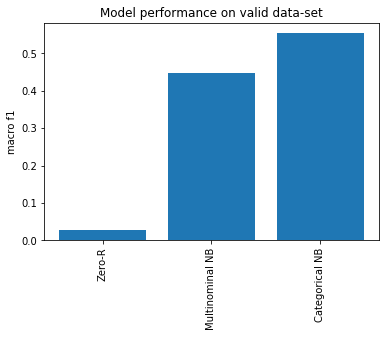

[('Zero-R', 0.027227722772277228),
 ('Multinominal NB', 0.44658737205993293),
 ('Categorical NB', 0.5535938550720744)]


In [643]:
plt.bar(x=model_names, height=m_f1s)
plt.ylabel("macro f1")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(model_names, m_f1s)))

In [646]:
test_preds = predict([models[2]], test_all_features)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

### inspect knn

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

 classic pop and rock       0.20      0.84      0.32        55
dance and electronica       0.15      0.29      0.20        45
                 folk       0.30      0.20      0.24        64
       jazz and blues       0.00      0.00      0.00        44
                metal       0.00      0.00      0.00        66
                  pop       0.72      0.49      0.58        74
                 punk       0.33      0.14      0.19        44
      soul and reggae       0.64      0.24      0.35        58

             accuracy                           0.28       450
            macro avg       0.29      0.27      0.24       450
         weighted avg       0.31      0.28      0.25       450



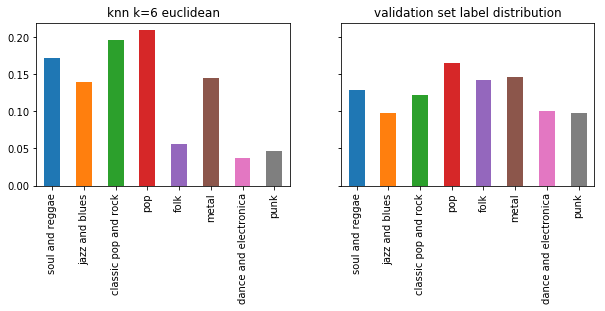

In [479]:
print(classification_report(valid_labels, preds[2], target_names=models[2].classes_))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_all_features.index), 
                                    valid_labels,
                                    title1="knn k=6 euclidean")

In [482]:
cm, _, _ = evaluate(preds[2], valid_labels.values.ravel())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5,1,'knn confusion matrix')

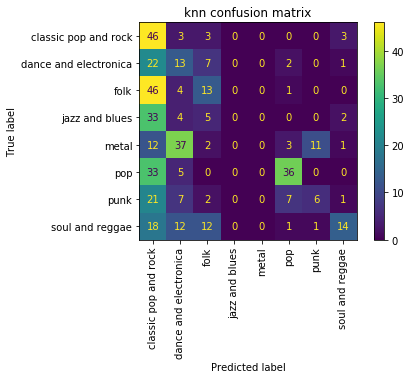

In [487]:
plot_confusion_matrix(models[2], 
                      valid_all_features, 
                      valid_labels.values.ravel(),
                      xticks_rotation='vertical'
                     )
plt.title("knn confusion matrix")

In [493]:
# train_features.loc[train_labels[train_labels["genre"] == "classic pop and rock"].index]

In [517]:
train_all_features_standard_df = pd.DataFrame(train_all_features_standard, 
                                              index=train_all_features.index,
                                              columns=train_all_features.columns
                                             )
valid_all_features_standard_df = pd.DataFrame(valid_all_features_standard, 
                                              index=valid_all_features.index,
                                              columns=valid_all_features.columns
                                             )

In [525]:
import warnings
warnings.filterwarnings('ignore')

res = pd.DataFrame(columns=["valid title", "valid genre", "predict genre", "closest id", "closest genre", "distance"],
                   index=valid_labels.index
                  )

tmp = 0

for ind in valid_all_features.index:
    res.at[ind, "valid title"] = valid_features.loc[ind, "title"]
    res.at[ind, "valid genre"] = valid_labels.loc[ind, "genre"]
    res.at[ind, "predict genre"] = preds[2].loc[ind, "genre"]
    
    distance, train_id = float("inf"), None
    
    for i in train_all_features_standard_df.index:
        d = euclidean_distances(train_all_features_standard_df.loc[i, :].reshape(1, -1), 
                                valid_all_features_standard_df.loc[ind, :].reshape(1, -1))
        if d < distance:
            distance, train_id = d, i
        
        if d <= 0:
            break
    res.at[ind, "closest id"] = train_id
    res.at[ind, "closest genre"] = train_labels.loc[train_id, "genre"]
    res.at[ind, "distance"] = distance
    
    print(tmp, valid_labels.shape[0])
    tmp += 1

0 450
1 450
2 450
3 450
4 450
5 450
6 450
7 450
8 450
9 450
10 450
11 450
12 450
13 450
14 450
15 450
16 450
17 450
18 450
19 450
20 450
21 450
22 450
23 450
24 450
25 450
26 450
27 450
28 450
29 450
30 450
31 450
32 450
33 450
34 450
35 450
36 450
37 450
38 450
39 450
40 450
41 450
42 450
43 450
44 450
45 450
46 450
47 450
48 450
49 450
50 450
51 450
52 450
53 450
54 450
55 450
56 450
57 450
58 450
59 450
60 450
61 450
62 450
63 450
64 450
65 450
66 450
67 450
68 450
69 450
70 450
71 450
72 450
73 450
74 450
75 450
76 450
77 450
78 450
79 450
80 450
81 450
82 450
83 450
84 450
85 450
86 450
87 450
88 450
89 450
90 450
91 450
92 450
93 450
94 450
95 450
96 450
97 450
98 450
99 450
100 450
101 450
102 450
103 450
104 450
105 450
106 450
107 450
108 450
109 450
110 450
111 450
112 450
113 450
114 450
115 450
116 450
117 450
118 450
119 450
120 450
121 450
122 450
123 450
124 450
125 450
126 450
127 450
128 450
129 450
130 450
131 450
132 450
133 450
134 450
135 450
136 450
137 450
138 45

In [543]:
missed = res[res["valid genre"] != res["predict genre"]]
missed[missed["predict genre"] == "classic pop and rock"]["closest genre"].value_counts()

classic pop and rock     107
dance and electronica     32
pop                       18
folk                      14
soul and reggae            8
punk                       4
jazz and blues             1
metal                      1
Name: closest genre, dtype: int64

### inspect Gnb

#### correlation

In [602]:
correlation = train_all_features.iloc[:, -200:].corr()

In [605]:
high_corr = []

for i in correlation.index:
    for j in correlation.index:
        if i != j:
            if correlation.loc[i, j] >= 0.7:
                high_corr.append((i, j))
high_corr

[('zijn', 'zo'),
 ('zo', 'zijn'),
 ('loudness', 'vect_1'),
 ('loudness', 'vect_29'),
 ('loudness', 'vect_42'),
 ('loudness', 'vect_43'),
 ('loudness', 'vect_44'),
 ('loudness', 'vect_45'),
 ('loudness', 'vect_46'),
 ('loudness', 'vect_47'),
 ('loudness', 'vect_48'),
 ('loudness', 'vect_49'),
 ('loudness', 'vect_53'),
 ('vect_1', 'loudness'),
 ('vect_1', 'vect_29'),
 ('vect_2', 'vect_25'),
 ('vect_6', 'vect_18'),
 ('vect_6', 'vect_23'),
 ('vect_16', 'vect_18'),
 ('vect_16', 'vect_20'),
 ('vect_16', 'vect_22'),
 ('vect_16', 'vect_23'),
 ('vect_18', 'vect_6'),
 ('vect_18', 'vect_16'),
 ('vect_18', 'vect_20'),
 ('vect_18', 'vect_22'),
 ('vect_18', 'vect_23'),
 ('vect_19', 'vect_24'),
 ('vect_20', 'vect_16'),
 ('vect_20', 'vect_18'),
 ('vect_20', 'vect_22'),
 ('vect_20', 'vect_23'),
 ('vect_20', 'vect_61'),
 ('vect_22', 'vect_16'),
 ('vect_22', 'vect_18'),
 ('vect_22', 'vect_20'),
 ('vect_22', 'vect_23'),
 ('vect_22', 'vect_61'),
 ('vect_22', 'vect_123'),
 ('vect_23', 'vect_6'),
 ('vect_23'

In [607]:
correlation.loc['loudness', ['vect_1', 'vect_29']]

vect_1     0.945383
vect_29    0.770170
Name: loudness, dtype: float64

#### inspect

                       precision    recall  f1-score   support

 classic pop and rock       0.28      0.45      0.35        55
dance and electronica       0.65      0.24      0.35        45
                 folk       0.64      0.25      0.36        64
       jazz and blues       0.44      0.64      0.52        44
                metal       0.85      0.83      0.84        66
                  pop       0.79      1.00      0.88        74
                 punk       0.90      0.43      0.58        44
      soul and reggae       0.65      0.86      0.74        58

             accuracy                           0.62       450
            macro avg       0.65      0.59      0.58       450
         weighted avg       0.66      0.62      0.60       450



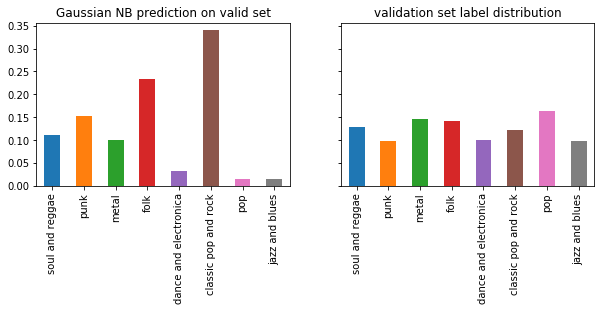

In [707]:
print(classification_report(valid_labels, preds[1], target_names=models[1].classes_))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_all_features.index), 
                                    valid_labels,
                                    title1="Gaussian NB prediction on valid set")

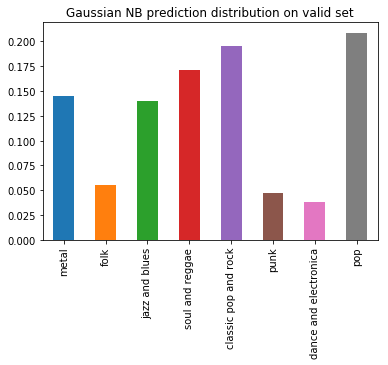

In [621]:
xs = ["metal", "folk", "jazz and blues", "soul and reggae",
      "classic pop and rock", "punk", "dance and electronica", "pop"]

(preds[1]["genre"].value_counts() / sum(valid_labels["genre"].value_counts()))[xs].plot(
    kind='bar')
plt.title('Gaussian NB prediction distribution on valid set')
plt.show()

Text(0.5,1,'Gnb confusion matrix')

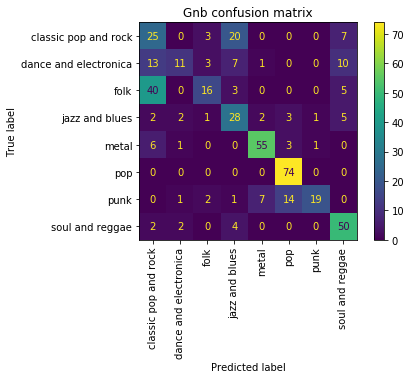

In [706]:
plot_confusion_matrix(models[1], 
                      valid_all_features, 
                      valid_labels.values.ravel(),
                      xticks_rotation='vertical'
                     )
plt.title("Gnb confusion matrix")

## error analysis

In [547]:
train_sizes_all = []
train_scores_all = []
test_scores_all = []
fit_times_all = []

for i, m in enumerate(models[1:]): # skip 0-R
    train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(m, 
                           train_all_features, 
                           train_labels.values.ravel(), 
                           cv=5, 
                           shuffle=True,
                           random_state=RANDOM_STATE,
                           return_times=True
                          )
    train_sizes_all.append(train_sizes)
    train_scores_all.append(train_scores)
    test_scores_all.append(test_scores)
    fit_times_all.append(fit_times)
    
    print(i, model_names[i+1], len(models))

0 Gaussian NB 6
1 Knn 6
2 Decision tree 6
3 Random forest 6
4 Multi-layer perceptron 6


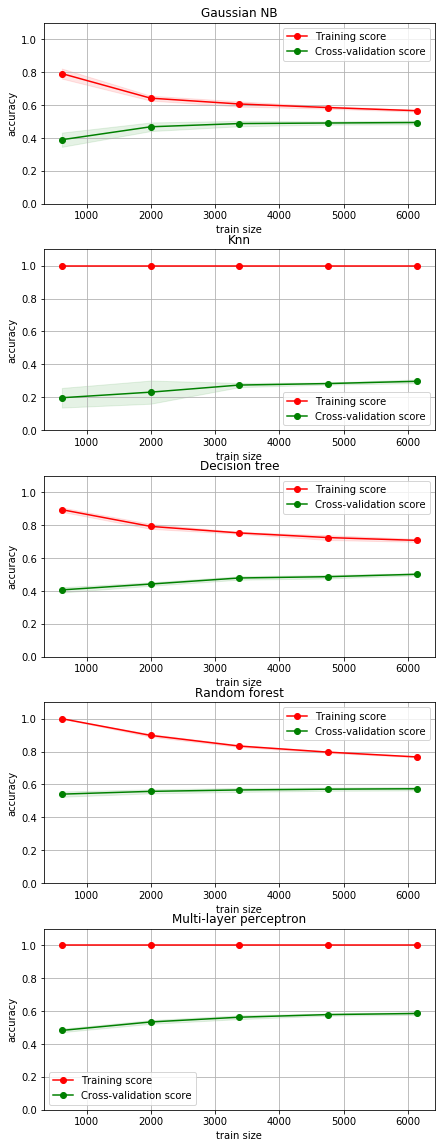

In [580]:
_, axes = plt.subplots(5, 1, figsize=(7, 20))
plt.subplots_adjust(hspace=0.25)

for i in range(1, len(models)):
#     print(model_names[i])
    train_scores_mean = np.mean(train_scores_all[i-1], axis=1)
    train_scores_std = np.std(train_scores_all[i-1], axis=1)
    test_scores_mean = np.mean(test_scores_all[i-1], axis=1)
    test_scores_std = np.std(test_scores_all[i-1], axis=1)
    fit_times_mean = np.mean(fit_times_all[i-1], axis=1)
    fit_times_std = np.std(fit_times_all[i-1], axis=1)

    axes[i-1].grid()
    axes[i-1].fill_between(train_sizes_all[i-1], train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[i-1].fill_between(train_sizes_all[i-1], test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[i-1].plot(train_sizes_all[i-1], train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[i-1].plot(train_sizes_all[i-1], test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[i-1].set_ylim([0, 1.1])
    axes[i-1].set_ylabel("accuracy")
    axes[i-1].set_xlabel("train size")
    axes[i-1].set_title(model_names[i])
    axes[i-1].legend(loc="best")

plt.savefig("error1")

In [573]:
train_sizes_all2 = []
train_scores_all2 = []
test_scores_all2 = []
fit_times_all2 = []

for i, m in enumerate(models[1:]): # skip 0-R
    train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(m, 
                           train_all_features, 
                           train_labels.values.ravel(), 
                           cv=5, 
                           shuffle=True,
                           random_state=RANDOM_STATE,
                           return_times=True,
                           scoring="f1_macro"
                          )
    train_sizes_all2.append(train_sizes)
    train_scores_all2.append(train_scores)
    test_scores_all2.append(test_scores)
    fit_times_all2.append(fit_times)
    
    print(i, model_names[i+1], len(models))

0 Gaussian NB 6
1 Knn 6
2 Decision tree 6
3 Random forest 6
4 Multi-layer perceptron 6


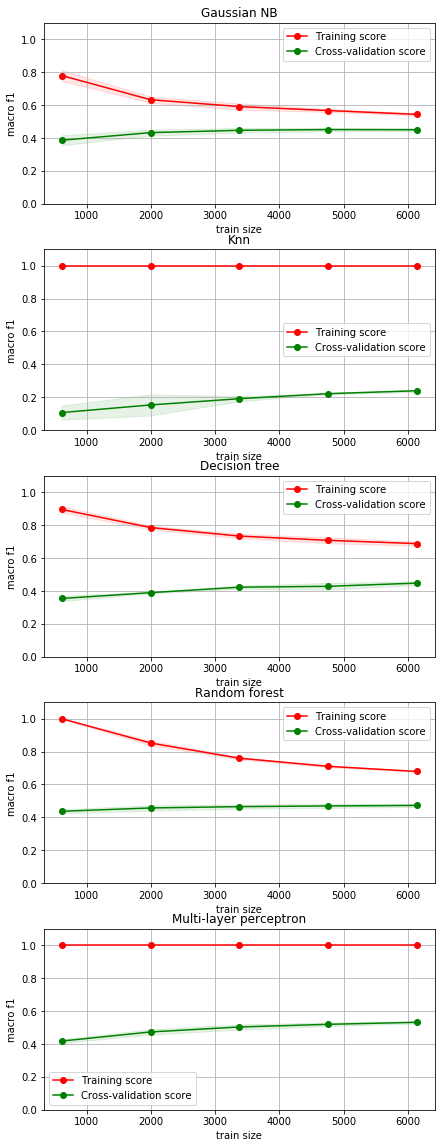

In [579]:
_, axes = plt.subplots(5, 1, figsize=(7, 20))
plt.subplots_adjust(hspace=0.25)

for i in range(1, len(models)):
#     print(model_names[i])
    train_scores_mean = np.mean(train_scores_all2[i-1], axis=1)
    train_scores_std = np.std(train_scores_all2[i-1], axis=1)
    test_scores_mean = np.mean(test_scores_all2[i-1], axis=1)
    test_scores_std = np.std(test_scores_all2[i-1], axis=1)
    fit_times_mean = np.mean(fit_times_all2[i-1], axis=1)
    fit_times_std = np.std(fit_times_all2[i-1], axis=1)

    axes[i-1].grid()
    axes[i-1].fill_between(train_sizes_all[i-1], train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[i-1].fill_between(train_sizes_all[i-1], test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[i-1].plot(train_sizes_all[i-1], train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[i-1].plot(train_sizes_all[i-1], test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[i-1].set_ylabel("macro f1")
    axes[i-1].set_ylim([0, 1.1])
    axes[i-1].set_xlabel("train size")
    axes[i-1].set_title(model_names[i])
    axes[i-1].legend(loc="best")

plt.savefig("error2")

## ensemble learning

### boosting Gnb

#### hyper-parameter tuning

In [749]:
gnb_ada_discrete = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=21,
    learning_rate=1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns = []
train_f1s = []

In [750]:
for i in range(1, 56):
    ns.append(i)
    gnb_ada_discrete.set_params(n_estimators=i)
    
    scores = cross_val_score(estimator=gnb_ada_discrete, 
                    X=train_all_features, 
                    y=train_labels.values.ravel(), 
                    cv=5,
                    scoring='f1_macro')
    train_f1s.append(np.mean(scores))
    
    print(i, train_f1s[-1])

1 0.44954506564133023
2 0.44954506564133023
3 0.4907536619631535
4 0.4716838477608872
5 0.47437735819921156
6 0.46885493146507856
7 0.47376608024160216
8 0.4814647123708621
9 0.48531839940898325
10 0.48406019097121816
11 0.4839136960255255
12 0.48817808918588657
13 0.4875599218132004
14 0.49322922215555254
15 0.49468130702936924
16 0.49636618255333154
17 0.4940741328765158
18 0.49481234579872985
19 0.5000594417074374
20 0.5017177946420661
21 0.5030761888995301
22 0.5059562757230187
23 0.5071184662171423
24 0.5102928485634524
25 0.510691148962706
26 0.5105116545251838
27 0.5125593893283058
28 0.5120553994434319
29 0.5118395132258378
30 0.514910808483171
31 0.5116547393567088
32 0.5113471409537307
33 0.5111134397896668
34 0.5147495301433584
35 0.5143858219444986
36 0.51285669529886
37 0.5126846756824062
38 0.5122321588850969
39 0.5154869499259126
40 0.5134839052575085
41 0.5138069209455447
42 0.5150900668142022
43 0.5165440532960538
44 0.5162916499764693
45 0.5174804741837009
46 0.515975

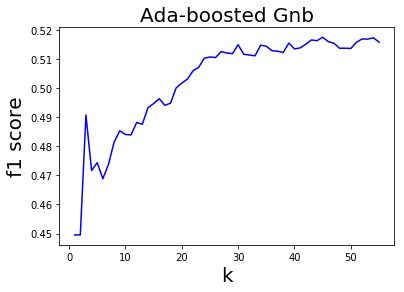

n_estimators maximize f1-score : 45 with 0.5174804741837009


In [751]:
draw_k_line_chart(ns, train_f1s, "f1 score", "Ada-boosted Gnb")
boost_gnb_best_n_estimators = ns[np.argmax(train_f1s)]
print("n_estimators maximize f1-score :", boost_gnb_best_n_estimators, 
      "with", train_f1s[np.argmax(train_f1s)])

#### comparison

In [688]:
Nbs = [
    GaussianNB(),
    AdaBoostClassifier(
        GaussianNB(),
        n_estimators=45,
        learning_rate=1,
        algorithm="SAMME",
        random_state=RANDOM_STATE
    )
]

Nbs_name = ["Gnb", "Ada-boosted Gnb"]

In [689]:
Nbs = train(Nbs, train_all_features, train_labels)

In [690]:
preds = predict(Nbs, valid_all_features)

In [691]:
m_f1s = []
m_acc = []

for p in preds:
    _, acc, pref = evaluate(p, valid_labels.values.ravel())
    m_acc.append(acc)
    m_f1s.append(pref[2])

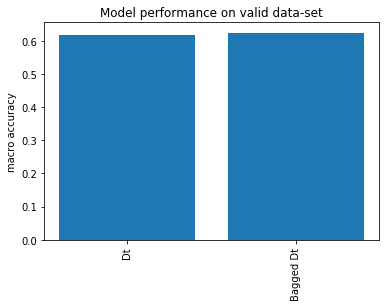

[('Gnb', 0.6177777777777778), ('Ada-boosted Gnb', 0.6244444444444445)]


In [692]:
plt.bar(x=Dts_name, height=m_acc)
plt.ylabel("macro accuracy")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(Nbs_name, m_acc)))

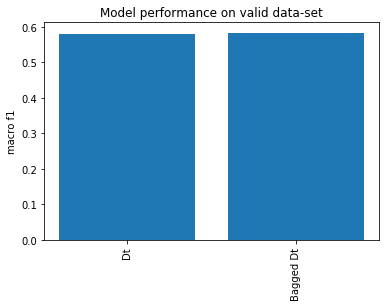

[('Gnb', 0.5791759087379859), ('Ada-boosted Gnb', 0.5832981026072412)]


In [693]:
plt.bar(x=Dts_name, height=m_f1s)
plt.ylabel("macro f1")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(Nbs_name, m_f1s)))

#### error analysis

In [695]:
train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(AdaBoostClassifier(
                                GaussianNB(),
                                n_estimators=45,
                                learning_rate=1,
                                algorithm="SAMME",
                                random_state=RANDOM_STATE
                            ), 
                           train_all_features, 
                           train_labels.values.ravel(), 
                           cv=5, 
                           shuffle=True,
                           random_state=RANDOM_STATE,
                           return_times=True
                          )

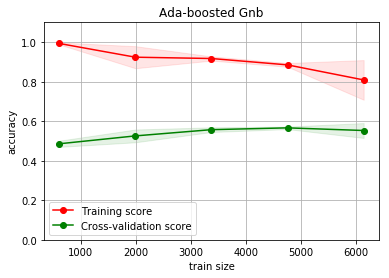

In [696]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim([0, 1.1])
plt.ylabel("accuracy")
plt.xlabel("train size")
plt.title("Ada-boosted Gnb")
plt.legend(loc="best")

In [697]:
train_sizes2, train_scores2, test_scores2, fit_times2, _ = \
        learning_curve(AdaBoostClassifier(
                                GaussianNB(),
                                n_estimators=45,
                                learning_rate=1,
                                algorithm="SAMME",
                                random_state=RANDOM_STATE
                            ), 
                       train_all_features, 
                       train_labels.values.ravel(), 
                       cv=5, 
                       shuffle=True,
                       random_state=RANDOM_STATE,
                       return_times=True,
                       scoring="f1_macro"
                      )

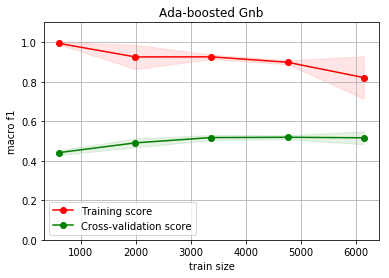

In [698]:
train_scores_mean = np.mean(train_scores2, axis=1)
train_scores_std = np.std(train_scores2, axis=1)
test_scores_mean = np.mean(test_scores2, axis=1)
test_scores_std = np.std(test_scores2, axis=1)
fit_times_mean = np.mean(fit_times2, axis=1)
fit_times_std = np.std(fit_times2, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim([0, 1.1])
plt.ylabel("macro f1")
plt.xlabel("train size")
plt.title("Ada-boosted Gnb")
plt.legend(loc="best")

#### inspect

In [711]:
gnb_ada_discrete = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=45,
    learning_rate=1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)
gnb_ada_discrete.fit(train_all_features, train_labels.values.ravel())

AdaBoostClassifier(algorithm='SAMME', base_estimator=GaussianNB(),
                   learning_rate=1, n_estimators=45, random_state=90049)

Text(0.5,1,'Ada-boosted Gnb confusion matrix')

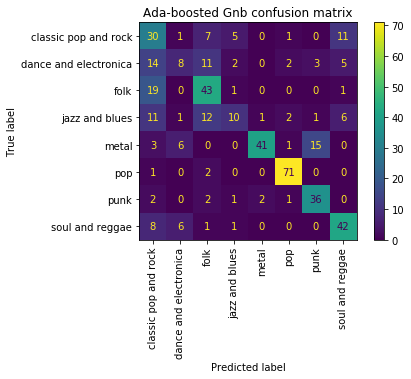

In [712]:
plot_confusion_matrix(gnb_ada_discrete, 
                      valid_all_features, 
                      valid_labels.values.ravel(),
                      xticks_rotation='vertical'
                     )
plt.title("Ada-boosted Gnb confusion matrix")

### bagging Dt

#### hyper-parameter tuning

In [ ]:
bagging_dt = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
                            n_estimators=10, 
                            random_state=RANDOM_STATE)

ns_bagging = []
train_bagging_f1s = []

In [ ]:
for i in range(1, 101):
    bagging_dt.set_params(n_estimators=i)
    
    scores = cross_val_score(estimator=bagging_dt, 
                    X=train_all_features, 
                    y=train_labels.values.ravel(), 
                    cv=5,
                    scoring='f1_macro')
    train_bagging_f1s.append(np.mean(scores))
    ns_bagging.append(i)
    
    print(i, train_bagging_f1s[-1])

In [ ]:
draw_k_line_chart(ns_bagging, train_bagging_f1s, "f1 score", "Dt bagging")
Dt_bagging_best_n_estimators = ns_bagging[np.argmax(train_bagging_f1s)]
print("n_estimators maximize f1-score :", Dt_bagging_best_n_estimators, 
      "with", train_bagging_f1s[np.argmax(train_bagging_f1s)])

#### comparison

In [664]:
Dts = [
    DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
    BaggingClassifier(
    base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
                            n_estimators=54, 
                            random_state=RANDOM_STATE)
]

Dts_name = ["Dt", "Bagged Dt"]

In [666]:
Dts = train(Dts, train_all_features, train_labels)

In [679]:
preds = predict(Dts, valid_all_features)

In [680]:
m_f1s = []
m_acc = []

for p in preds:
    _, acc, pref = evaluate(p, valid_labels.values.ravel())
    m_acc.append(acc)
    m_f1s.append(pref[2])

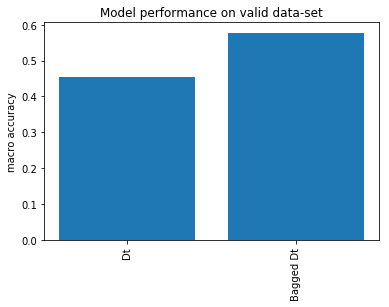

[('Dt', 0.4533333333333333), ('Bagged Dt', 0.5777777777777777)]


In [682]:
plt.bar(x=Dts_name, height=m_acc)
plt.ylabel("macro accuracy")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(Dts_name, m_acc)))

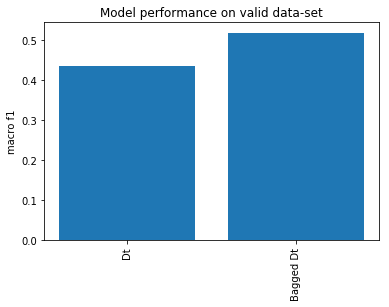

[('Dt', 0.4351733143531153), ('Bagged Dt', 0.5193925057031797)]


In [683]:
plt.bar(x=Dts_name, height=m_f1s)
plt.ylabel("macro f1")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(Dts_name, m_f1s)))

#### error analysis

In [667]:
train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(BaggingClassifier(
                            base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
                            n_estimators=54, 
                            random_state=RANDOM_STATE), 
                           train_all_features, 
                           train_labels.values.ravel(), 
                           cv=5, 
                           shuffle=True,
                           random_state=RANDOM_STATE,
                           return_times=True
                          )

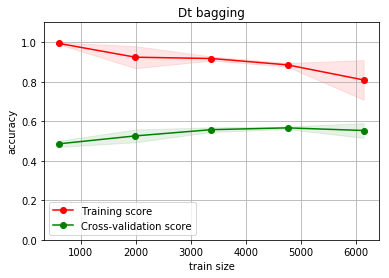

In [742]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim([0, 1.1])
plt.ylabel("accuracy")
plt.xlabel("train size")
plt.title("Dt bagging")
plt.legend(loc="best")

In [ ]:
train_sizes2, train_scores2, test_scores2, fit_times2, _ = \
        learning_curve(BaggingClassifier(
                        base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
                        n_estimators=54, 
                        random_state=RANDOM_STATE),
                       train_all_features, 
                       train_labels.values.ravel(), 
                       cv=5, 
                       shuffle=True,
                       random_state=RANDOM_STATE,
                       return_times=True,
                       scoring="f1_macro"
                      )

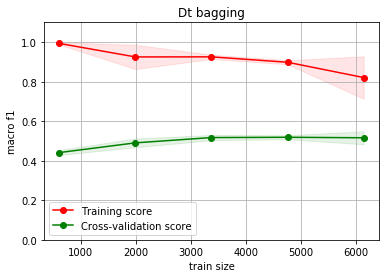

In [741]:
train_scores_mean = np.mean(train_scores2, axis=1)
train_scores_std = np.std(train_scores2, axis=1)
test_scores_mean = np.mean(test_scores2, axis=1)
test_scores_std = np.std(test_scores2, axis=1)
fit_times_mean = np.mean(fit_times2, axis=1)
fit_times_std = np.std(fit_times2, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim([0, 1.1])
plt.ylabel("macro f1")
plt.xlabel("train size")
plt.title("Dt bagging")
plt.legend(loc="best")

# End

In [ ]:
# Introduction to machine learning is fun!